## Step 1: Load the Dataset from Excel and Handle Missing Values

In [ ]:
pip install nltk

In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

# Download NLTK resources
nltk.download('punkt')

# Load the dataset
preprocessed_data = pd.read_excel('preprocessed_data.xlsx')

# Check for missing values
print(preprocessed_data['text'].isnull().sum(), preprocessed_data['gender'].isnull().sum())

# Option 1: Remove rows with missing values
preprocessed_data.dropna(subset=['text', 'gender'], inplace=True)

# Option 2: Fill missing values with a placeholder text
# preprocessed_data['text'].fillna('missing', inplace=True)
# preprocessed_data['gender'].fillna('missing', inplace=True)

# Reassign tweets and labels after handling missing values
tweets = preprocessed_data['text']
labels = preprocessed_data['gender']

# Function to preprocess text
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply preprocessing to tweets
tweets = tweets.apply(preprocess_text)

# Tokenization
tweets_tokenized = tweets.apply(word_tokenize)

# Stopword removal (optional)
stop_words = set(stopwords.words('english'))
tweets_filtered = tweets_tokenized.apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Stemming (optional)
stemmer = PorterStemmer()
tweets_stemmed = tweets_filtered.apply(lambda tokens: [stemmer.stem(word) for word in tokens])

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(tweets_stemmed, labels, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1 0


## Step 2: Creating Word Embeddings

### Word2Vec Feature Extraction

In [ ]:
pip install gensim

In [ ]:
#Train the Word2Vec model:

from gensim.models import Word2Vec

# Train Word2Vec model
model_w2v = Word2Vec(sentences=tweets_stemmed, vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model_w2v.save("word2vec.model")


In [ ]:
#Create document vectors by averaging word vectors for each tweet:

import numpy as np

def document_vector(doc):
    doc = [word for word in doc if word in model_w2v.wv]
    return np.mean(model_w2v.wv[doc], axis=0)

X_train_w2v = np.array([document_vector(doc) for doc in X_train])
X_test_w2v = np.array([document_vector(doc) for doc in X_test])


### GloVe Feature Extraction

In [ ]:
# Load GloVe embeddings

import os

def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = 'glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_file)

In [ ]:
#Create document vectors using GloVe embeddings:

def document_vector_glove(doc, embeddings_index, dim=100):
    word_vectors = [embeddings_index[word] for word in doc if word in embeddings_index]
    if len(word_vectors) == 0:
        return np.zeros(dim)
    doc_vector = np.mean(word_vectors, axis=0)
    return doc_vector


# Create document vectors for training and testing data
X_train_glove = np.array([document_vector_glove(doc, embeddings_index) for doc in X_train])
X_test_glove = np.array([document_vector_glove(doc, embeddings_index) for doc in X_test])

### Training SVM Model

In [ ]:
# Train and evaluate SVM model using Word2Vec features:

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# SVM with Word2Vec
svm_w2v = SVC(kernel='linear')
svm_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = svm_w2v.predict(X_test_w2v)
print("Word2Vec SVM Accuracy:", accuracy_score(y_test, y_pred_w2v))
print(classification_report(y_test, y_pred_w2v))

Word2Vec SVM Accuracy: 0.5503937007874016
              precision    recall  f1-score   support

           0       0.59      0.50      0.54      1353
           1       0.52      0.60      0.56      1187

    accuracy                           0.55      2540
   macro avg       0.55      0.55      0.55      2540
weighted avg       0.56      0.55      0.55      2540



In [ ]:
# Train and evaluate SVM model using GloVe features:

# SVM with GloVe
svm_glove = SVC(kernel='linear')
svm_glove.fit(X_train_glove, y_train)

y_pred_glove = svm_glove.predict(X_test_glove)
print("GloVe SVM Accuracy:", accuracy_score(y_test, y_pred_glove))
print(classification_report(y_test, y_pred_glove))

GloVe SVM Accuracy: 0.6216535433070867
              precision    recall  f1-score   support

           0       0.64      0.68      0.66      1353
           1       0.60      0.56      0.58      1187

    accuracy                           0.62      2540
   macro avg       0.62      0.62      0.62      2540
weighted avg       0.62      0.62      0.62      2540



# Visualisations

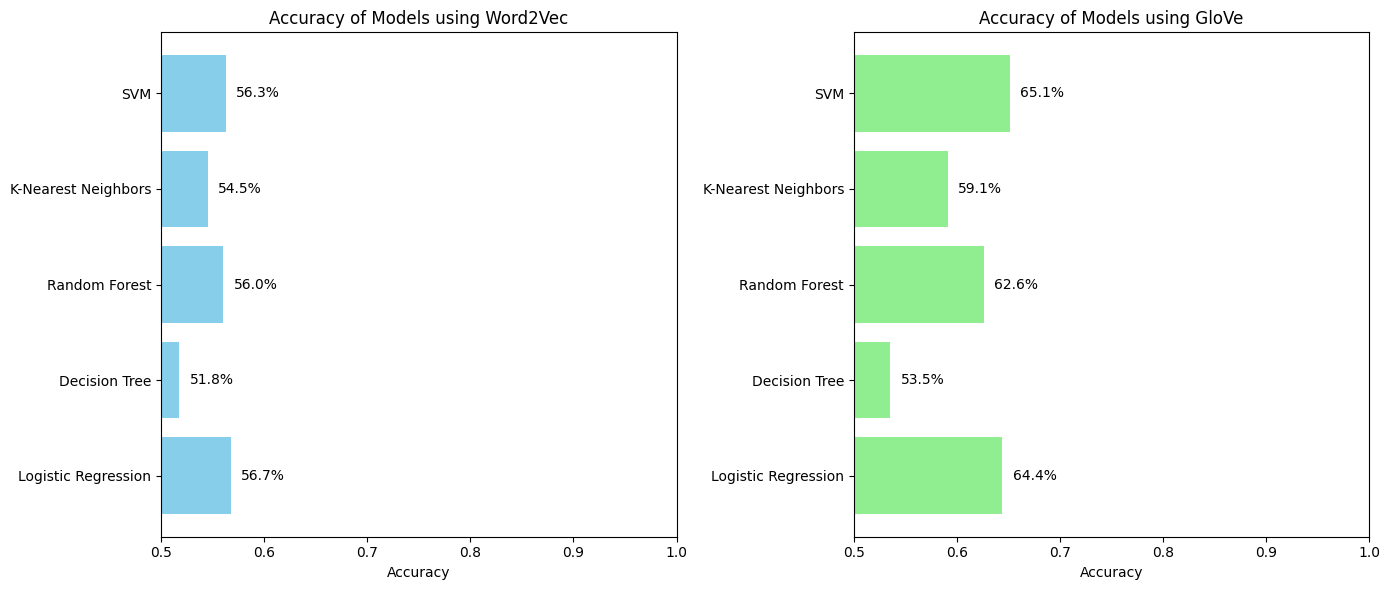

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import gensim
from gensim.models import Word2Vec
import requests
import zipfile

# Function to download GloVe embeddings
def download_glove(url, save_path):
    print("Downloading GloVe embeddings...")
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
    print("Download complete.")

# Function to extract GloVe embeddings
def extract_glove(zip_path, extract_to):
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

# Function to load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Function to create document vectors using GloVe
def document_vector_glove(doc, embeddings_index, dim=100):
    word_vectors = [embeddings_index[word] for word in doc if word in embeddings_index]
    if len(word_vectors) == 0:
        return np.zeros(dim)
    doc_vector = np.mean(word_vectors, axis=0)
    return doc_vector

# Load the dataset
preprocessed_data = pd.read_excel('preprocessed_data.xlsx')
tweets = preprocessed_data['text']
labels = preprocessed_data['gender']

# Handle missing values
preprocessed_data.dropna(subset=['text', 'gender'], inplace=True)
tweets = preprocessed_data['text']
labels = preprocessed_data['gender']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

# Tokenize the tweets
X_train_tokenized = X_train.apply(lambda x: x.split())
X_test_tokenized = X_test.apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.build_vocab(X_train_tokenized, progress_per=1000)
word2vec_model.train(X_train_tokenized, total_examples=word2vec_model.corpus_count, epochs=10)


glove_file = 'glove.6B.100d.txt'

# Load GloVe embeddings
embeddings_index = load_glove_embeddings(glove_file)

# Create document vectors using Word2Vec
def document_vector_w2v(doc, model):
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

X_train_w2v = np.array([document_vector_w2v(doc, word2vec_model) for doc in X_train_tokenized])
X_test_w2v = np.array([document_vector_w2v(doc, word2vec_model) for doc in X_test_tokenized])

# Create document vectors using GloVe
X_train_glove = np.array([document_vector_glove(doc, embeddings_index) for doc in X_train_tokenized])
X_test_glove = np.array([document_vector_glove(doc, embeddings_index) for doc in X_test_tokenized])

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(kernel='linear')
}

# Lists to store accuracy scores
accuracy_scores_w2v = []
accuracy_scores_glove = []

# Train and evaluate each model using Word2Vec and GloVe features
for clf_name, clf in classifiers.items():
    # Using Word2Vec Features
    if 'Logistic Regression' in clf_name:
        clf_w2v = LogisticRegression(max_iter=1000)
    else:
        clf_w2v = clf

    clf_w2v.fit(X_train_w2v, y_train)
    y_pred_w2v = clf_w2v.predict(X_test_w2v)
    accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
    accuracy_scores_w2v.append(accuracy_w2v)

    # Using GloVe Features
    if 'Logistic Regression' in clf_name:
        clf_glove = LogisticRegression(max_iter=1000)
    else:
        clf_glove = clf

    clf_glove.fit(X_train_glove, y_train)
    y_pred_glove = clf_glove.predict(X_test_glove)
    accuracy_glove = accuracy_score(y_test, y_pred_glove)
    accuracy_scores_glove.append(accuracy_glove)

# Plotting the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Word2Vec Accuracy Plot
ax1.barh(list(classifiers.keys()), accuracy_scores_w2v, color='skyblue')
ax1.set_xlim(0.5, 1.0)  # Adjust the x-axis limits if necessary
ax1.set_xlabel('Accuracy')
ax1.set_title('Accuracy of Models using Word2Vec')
for i, v in enumerate(accuracy_scores_w2v):
    ax1.text(v + 0.01, i, f'{v*100:.1f}%', va='center')

# GloVe Accuracy Plot
ax2.barh(list(classifiers.keys()), accuracy_scores_glove, color='lightgreen')
ax2.set_xlim(0.5, 1.0)  # Adjust the x-axis limits if necessary
ax2.set_xlabel('Accuracy')
ax2.set_title('Accuracy of Models using GloVe')
for i, v in enumerate(accuracy_scores_glove):
    ax2.text(v + 0.01, i, f'{v*100:.1f}%', va='center')

plt.tight_layout()
plt.show()
